## Chapter 10, Example 2a (Multiplicative Noise)

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Set random seed for reproducibility
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

# Create a figures directory if it doesn't exist
if not os.path.isdir('figures'):
    os.makedirs('figures')

# Parameters
noise_prob = 0.1
n_hidden = 500
batch_size = 128
n_epochs = 50
learning_rate = 0.1

In [3]:
# MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 121875371.91it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105061312.94it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44828335.09it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20639792.81it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Add noise to the images

The `add_noise` function takes an image tensor as input and applies random noise to it. This technique is known as data augmentation and helps prevent overfitting, making models more robust.

### Creating Noise

- The `torch.bernoulli` function is used to create a tensor (`noise`) with the same shape as the input image (`img`).
- The tensor contains random values of 0 or 1, where the probability of 1 is determined by the noise level (here, `1 - 0.1 = 0.9`).
- Essentially, each pixel has a 10% chance of being turned off (multiplied by zero).

### Applying Noise

- The original image tensor (`img`) is multiplied by the `noise` tensor.
- Because the noise contains zeros and ones, this process effectively turns off various pixels in the original image, thereby adding noise.
- The result is a slightly degraded version of the original image, with 10% of its pixels randomly turned off.


In [4]:
# Add noise to images
def add_noise(img):
    noise = torch.bernoulli(torch.full_like(img, 1 - noise_prob))  # 0.1 is the noise level
    noisy_img = img * noise
    return noisy_img

## Defining the Autoencoder Class

In the code provided, we are defining a simple autoencoder using PyTorch. Here's a breakdown of its structure and functionality:

### Class Initialization

- The `Autoencoder` class inherits from `nn.Module`, which is a standard practice when defining any neural network model in PyTorch.

- Within the `__init__` method, we define the architecture of our autoencoder. It consists of two main parts: the encoder and the decoder.

    - `self.encoder`: This is a linear layer that reduces the dimensionality of the input data, compressing it into a lower-dimensional space. The layer's size is defined by `n_input` (the size of the input data) and `n_hidden` (the size of the compressed representation).
    
    - `self.decoder`: Another linear layer that reconstructs the original data from its compressed form. The layer's size is the reverse of the encoder, defined by `n_hidden` and `n_input`, respectively.

- The weights of the neural network are initialized following a specific strategy:

    - For the encoder, we initialize the weights with a normal distribution with a mean of `0.0` and a standard deviation of `1 / np.sqrt(n_input)`. This specific choice helps in stabilizing the learning process by controlling the variance of the weights.
    
    - For the decoder, we are using a technique called "tied weights," where the decoder's weights are the transpose of the encoder's weights (`self.encoder.weight.data.T`). This not only reduces the number of parameters in the model but also imposes a form of regularization.

### Forward Pass

- The `forward` method defines the sequence of operations the model performs to generate an output from an input.

    - The input data `x` is first passed through the encoder, compressed, and then the sigmoid activation function is applied. The sigmoid function ensures the output is in the range (0, 1), making the model's behavior more predictable and the learning process more stable.
    
    - The compressed data is then passed through the decoder, attempting to reconstruct the original input. Again, the sigmoid activation function is applied to the output.

- The final output is the reconstructed data from the original input, ideally with reduced noise or removed irrelevant details.

### Model Instantiation

- Finally, we create an instance of the `Autoencoder` class with `28*28` input size (typical for MNIST images, which are 28x28 pixels) and `n_hidden` representing the size of our hidden (compressed) layer. This instance `model` is what we will train and use for encoding/decoding tasks.


In [5]:
# Model
class Autoencoder(nn.Module):
    def __init__(self, n_input, n_hidden):
        super(Autoencoder, self).__init__()
        # Linear function
        self.encoder = nn.Linear(n_input, n_hidden)
        self.decoder = nn.Linear(n_hidden, n_input)

        # Weight initialization
        self.encoder.weight.data.normal_(0.0, 1 / np.sqrt(n_input))
        self.decoder.weight.data = self.encoder.weight.data.T  # tied weights

    def forward(self, x):
        x = torch.sigmoid(self.encoder(x))
        x = torch.sigmoid(self.decoder(x))
        return x

model = Autoencoder(28*28, n_hidden)

In [6]:
def loss_function(y, original):

    # Calculate the mean squared error (MSE) loss
    mse_loss = torch.mean(torch.sum((original - y) ** 2, dim=1))

    return mse_loss

In [7]:
# Optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training
loss_values = []
for epoch in range(n_epochs):
    model.train()
    train_losses = []
    for data in train_loader:
        img, _ = data
        noisy_img = add_noise(img)
        noisy_img = noisy_img.view(noisy_img.size(0), -1)  # flatten
        img = img.view(img.size(0), -1)  # flatten

        # Forward pass
        output = model(noisy_img)
        loss = loss_function(output, img)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
    avg_loss = np.mean(train_losses)
    loss_values.append(avg_loss)
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/50], Loss: 20.6823
Epoch [2/50], Loss: 10.5709
Epoch [3/50], Loss: 8.3441
Epoch [4/50], Loss: 7.2062
Epoch [5/50], Loss: 6.4970
Epoch [6/50], Loss: 6.0117
Epoch [7/50], Loss: 5.6534
Epoch [8/50], Loss: 5.3846
Epoch [9/50], Loss: 5.1688
Epoch [10/50], Loss: 4.9966
Epoch [11/50], Loss: 4.8541
Epoch [12/50], Loss: 4.7279
Epoch [13/50], Loss: 4.6284
Epoch [14/50], Loss: 4.5352
Epoch [15/50], Loss: 4.4471
Epoch [16/50], Loss: 4.3910
Epoch [17/50], Loss: 4.3304
Epoch [18/50], Loss: 4.2760
Epoch [19/50], Loss: 4.2223
Epoch [20/50], Loss: 4.1755
Epoch [21/50], Loss: 4.1345
Epoch [22/50], Loss: 4.1003
Epoch [23/50], Loss: 4.0609
Epoch [24/50], Loss: 4.0281
Epoch [25/50], Loss: 3.9951
Epoch [26/50], Loss: 3.9701
Epoch [27/50], Loss: 3.9381
Epoch [28/50], Loss: 3.9139
Epoch [29/50], Loss: 3.8956
Epoch [30/50], Loss: 3.8697
Epoch [31/50], Loss: 3.8444
Epoch [32/50], Loss: 3.8273
Epoch [33/50], Loss: 3.8018
Epoch [34/50], Loss: 3.7921
Epoch [35/50], Loss: 3.7704
Epoch [36/50], Loss: 3.7508

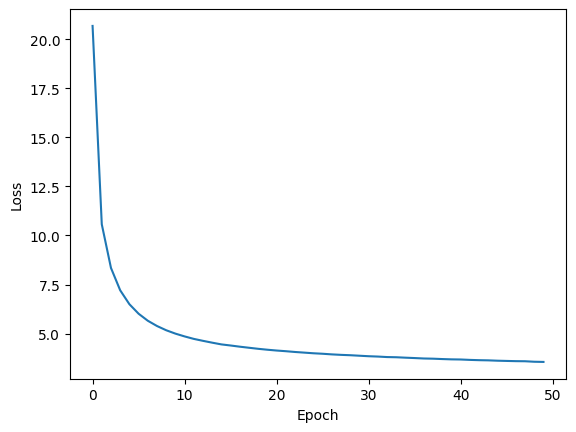

In [8]:
# Plotting the training loss
plt.figure()
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('./figures/10.2a_1.png')

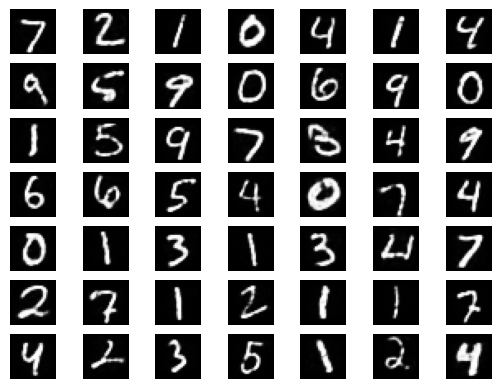

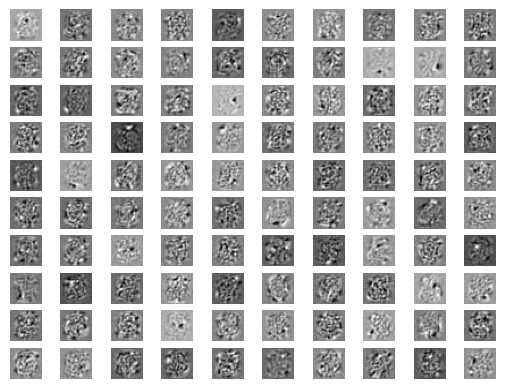

In [9]:
# Visualization
def visualize_output(images, noisy_images, epoch):
    # Plot original images, noisy images, and the reconstructions from the autoencoder
    model.eval()
    with torch.no_grad():
        noisy_images_flat = noisy_images.view(noisy_images.size(0), -1)
        outputs = model(noisy_images_flat).view(-1, 1, 28, 28)
        outputs.clamp_(0, 1)  # Values might be outside [0, 1] range, clamp to ensure valid pixel range

        # Create a grid of images including original, noisy, and reconstructed images
        images = images.cpu()
        noisy_images = noisy_images.cpu()
        outputs = outputs.cpu()

        # Display original images
        for i in range(49):
            plt.subplot(7, 7, i+1)
            plt.imshow(images[i][0], cmap='gray')
            plt.axis('off')
        plt.savefig(f'./figures/10.2a_3.png')

        # Display noisy images
        for i in range(49):
            plt.subplot(7, 7, i+1)
            plt.imshow(noisy_images[i][0], cmap='gray')
            plt.axis('off')
        plt.savefig(f'./figures/10.2a_4.png')

        # Display reconstructed images
        for i in range(49):
            plt.subplot(7, 7, i+1)
            plt.imshow(outputs[i][0], cmap='gray')
            plt.axis('off')
        plt.savefig(f'./figures/10.2a_5.png')

# Testing with the test dataset
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
test_images, _ = next(iter(test_loader))

noisy_test_images = add_noise(test_images)
visualize_output(test_images, noisy_test_images, n_epochs)

# Weights visualization
weights = model.encoder.weight.data.view(n_hidden, 28, 28).cpu()
plt.figure()
for i in range(100):  # displaying 100 weights
    plt.subplot(10, 10, i+1)
    plt.imshow(weights[i], cmap="gray")
    plt.axis('off')
plt.savefig('./figures/10.2a_2.png')